In [1]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

In [2]:
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [3]:
algorithms = [
    ("Robust covariance",
     EllipticEnvelope(contamination=outliers_fraction, random_state=42),
     ),
    ("One-Class SVM",
     svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)
     ),
    ("One-Class SVM (SGD)", # the SGDOneClassSVM must be used in a pipeline with a kernel approximation
     make_pipeline(
         Nystroem(gamma=0.1, random_state=42, n_components=150),
         SGDOneClassSVM(
             nu=outliers_fraction,
             shuffle=True,
             fit_intercept=True,
             random_state=42,
             tol=1e-6,
            ),
        ),
     ),
    ("Isolation Forest",
     IsolationForest(contamination=outliers_fraction, random_state=42),
     ),
]

In [4]:
# Create datasets (two dimensions)
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0*(make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0] - np.array([0.5, 0.25])),
    14.0*(np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

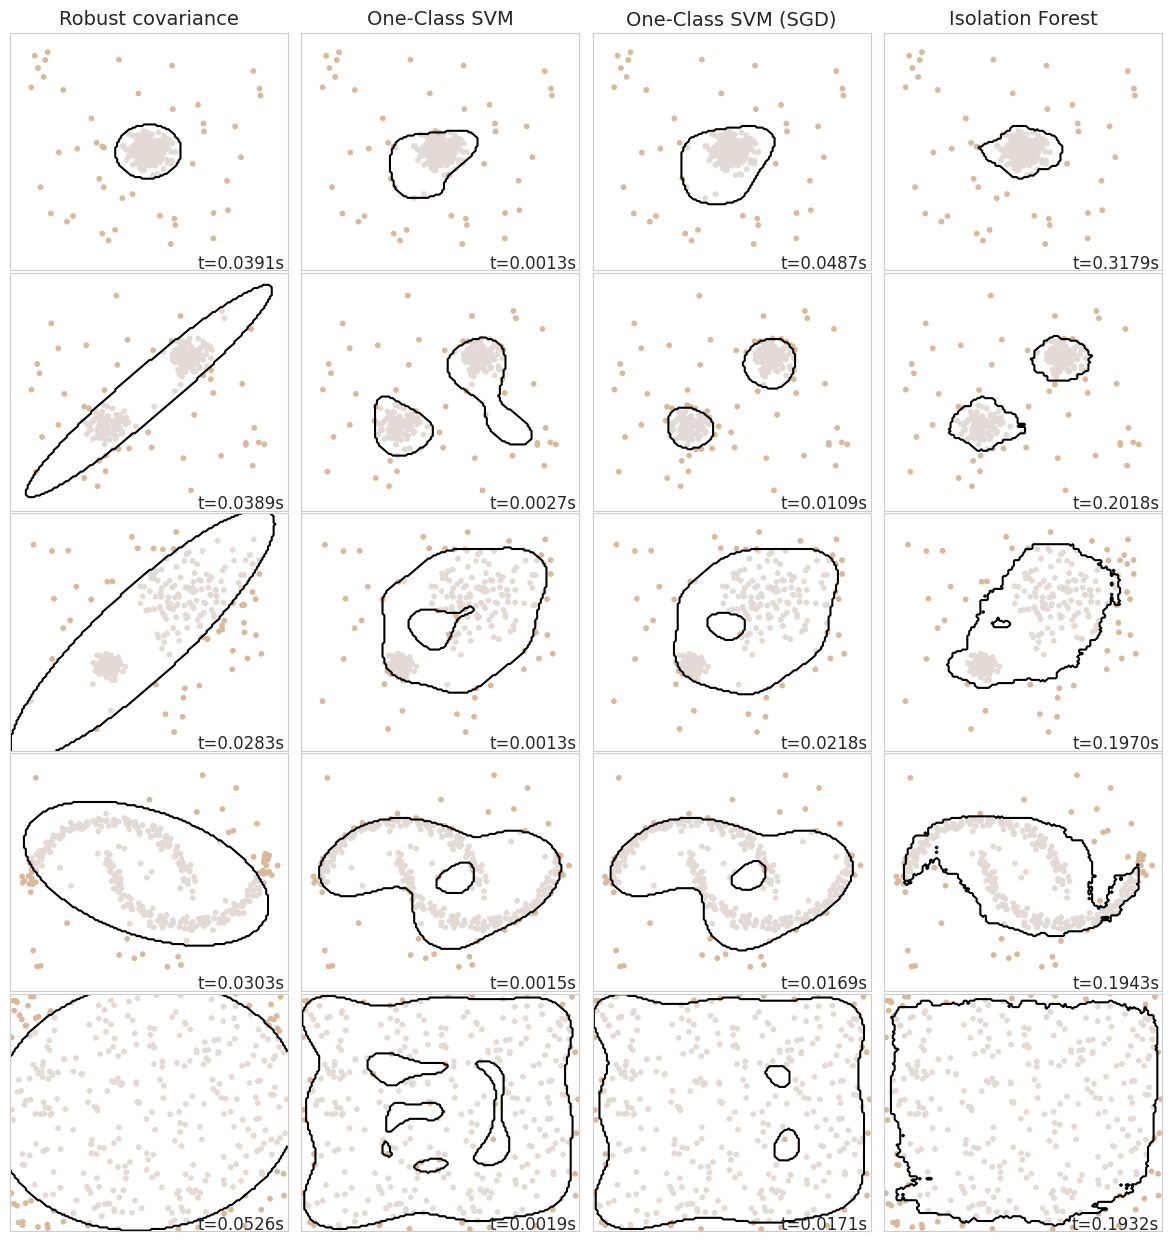

In [5]:
# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(algorithms)*2 + 4, 12.5))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)

        # fit the data and tag outliers
        y_pred = algorithm.fit_predict(X)

        # plot the levels lines and the points, data ravel array is the same, only black line is different
        Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=1.5, colors="black")

        colors = np.array(["#d9b99b", "#E3DAD5"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("t=%.4fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=12,
            horizontalalignment="right",
        )
        plot_num += 1
plt.show()

We can observe that iForest gives similar performance than OneClassSVM but it is slower (more than x10).
Now, we pick the model that gives better performance visually, which is SGDOneClassSVM and we will use it particularly on the second dataset.

SGD means Stochastic Gradient Descent

In [6]:
model = make_pipeline(
         Nystroem(gamma=0.1, n_components=150, random_state=42, n_jobs=-1),
         SGDOneClassSVM(
             nu=outliers_fraction, # an upper bound for training errors.
             shuffle=True,
             fit_intercept=True,
             random_state=42,
             tol=1e-6, # Stopping criterion. Stops when loss > previous_loss - tol
    ),
)

In [7]:
# create dataset
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
X = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0]

# Add outliers
rng = np.random.RandomState(42)
X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

In [8]:
model.fit(X)

Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.1, n_components=150, n_jobs=-1,
                          random_state=42)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(nu=0.15, random_state=42, tol=1e-06))])

In [9]:
data = {'feature_1': X[:, 0],
        'feature_2': X[:, 1],
        'outlier': model.fit_predict(X)}

df = pd.DataFrame(data)
df['outlier'] = df['outlier'].replace(-1, 0)

class 1 (inliers) = 265
class 0 (ouliers) = 35


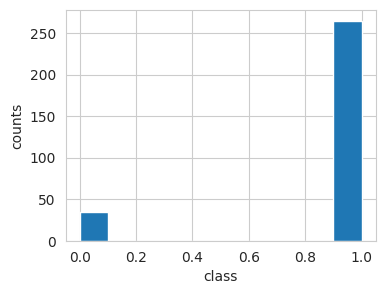

In [10]:
plt.figure(figsize=(4, 3))
plt.hist(df.outlier)

plt.xlabel("class")
plt.ylabel("counts")

print(f"class 1 (inliers) = {len(df.query('outlier == 1'))}")
print(f"class 0 (ouliers) = {len(df.query('outlier == 0'))}")

In [11]:
def ContourPlot(X, y, estimator):

    colors=['red', 'blue'] # for data points

    xx, yy = np.meshgrid(np.linspace(-7, 7, 1000), np.linspace(-7, 7, 1000))

    DecisionBoundaryDisplay.from_estimator(model, X, response_method="auto",
                                           grid_resolution=1000, plot_method='pcolormesh',
                                           xlabel=X.columns[0], ylabel=X.columns[1],
                                           alpha=0.45, cmap='viridis',
                                           )
    for class_label, color in zip(np.unique(y), colors):
        mask = y == class_label

        if class_label == 0: label = "Outliers"
        else: label = "Inliers"

        plt.scatter(X.iloc[:, 0:1][mask], X.iloc[:, 1:][mask],
                    label=label, edgecolor="k", color=color)

    # plot the levels lines and the points, data ravel array is the same, only black line is different
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=1.5, colors="black")

    plt.legend()
    plt.show()

/home/jordan/Desktop/Python_examples/scikit-learn/venv/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(


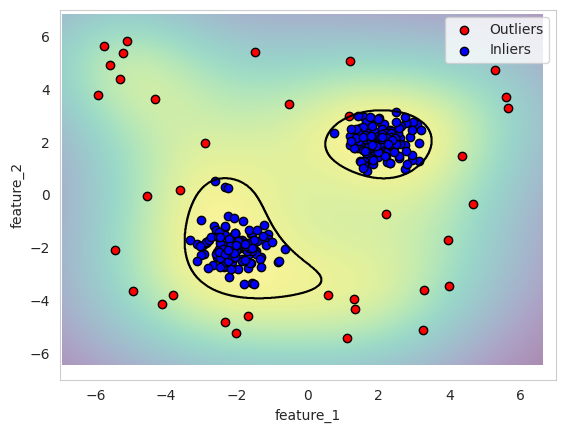

In [12]:
ContourPlot(estimator=model, X=df[['feature_1', 'feature_2']], y=df.outlier)

The dense region (in yellow color) cumulates more points, unlike the purple region
If wished remove outliers, we can apply df.query('outlier != 0'), where outliers have value 0.